<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/COMP5623M_CW2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OCOM5203M Practical Assignment 2 - Image Caption Generation [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image to text model.
> 3. Use and compare two different text similarity metrics for evaluating an image to text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you would like to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using Python and PyTorch, and refer to the notebooks and exercises provided.

This coursework will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5029.

To download the data:

> 1. **Images**: download the zip file "coco_subset_images.zip (812MB)" [here](https://leeds365-my.sharepoint.com/:f:/g/personal/scsrss_leeds_ac_uk/EnVzgHGd-fhIhTcnxdK5hawBpGQz9isq8Bo8-Xhlwf6uwQ?e=e3LEru).
> 2. **Reference captions**: on the COCO [download page](https://cocodataset.org/#download), download the file named "2017 Train/Val annotations (241MB)". 
> 3. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name or the automatic grading will be affected.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.


Final note:

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username:

In [ ]:
ml20baya

Your full name:

In [ ]:
Buthaina Abdullah Alshareef

## Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from torchvision import datasets, transforms,utils
import json

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN). 

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks. 

We will first extract the feature representations of the images from the Encoder and save them (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]

### 1.1 EncoderCNN

Read through the template EncoderCNN class below and complete the class.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT = "/content/drive/MyDrive/CW2_AI/"

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last one
        self.resnet_d = torch.nn.Sequential(*(list(resnet.children())[:-1]))

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        #print("image", images.shape)
        # [64, 3, 128, 128]
        # pass the batch of images (images) to self.resnet_d
        # with torch.no_grad():
        features = self.resnet_d(images)

        #print("before", features.shape)
        features = features.reshape(features.size(0), -1)
        
        #print("after", features.shape)
        #print(len(outputs))
        # shape you want is [batch_size, feature_dims] for example, [64, 2048]

        # TO COMPLETE
        # remember no gradients are needed
        return features 


In [7]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

EncoderCNN(
  (resnet_d): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

### 1.2 Processing the images

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [8]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [9]:
class COCO(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_x = Image.open(self.df['path'][index])
        
        try:
            img_x = img_x.convert('RGB')
            
        except:
            pass
        
        if self.transform:
            img_x = self.transform(img_x)
        return img_x

In [10]:
coco_dir = ROOT + "images"
img_paths= []
img_name= []

for entry in os.scandir(coco_dir):
    if (entry.is_file()):
        img_paths.append(entry.path)
        img_name.append(entry.name)
            
data = {'path': img_paths}

coco_df = pd.DataFrame(data, columns=['path'])


print("length of coco images = ", len(coco_df), "image")
print(coco_df.head())

coco_dataset = COCO(
    df=coco_df,
    transform=data_transform,
)

coco_loader = DataLoader(
    coco_dataset,
    batch_size=15,
    shuffle=False,
    num_workers=6
)

length of coco images =  5029 image
                                                path
0  /content/drive/MyDrive/CW2_AI/images/000000516...
1  /content/drive/MyDrive/CW2_AI/images/000000540...
2  /content/drive/MyDrive/CW2_AI/images/000000368...
3  /content/drive/MyDrive/CW2_AI/images/000000205...
4  /content/drive/MyDrive/CW2_AI/images/000000229...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


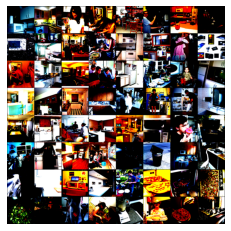

array([[[ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [-1.2873664, -1.2752753, -0.9186849],
        ...,
        [-1.6032423, -1.770086 , -1.66615  ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       ...,

       [[ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [-1.5537134, -

In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa

# single batch
dataiter = iter(coco_loader)
images = dataiter.next()

#print(images.size())

#disply images
timshow(utils.make_grid(images))

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    9233 MB |   14688 MB |   52385 MB |   43151 MB |\n|       from large pool |    9150 MB |   14605 MB |   52248 MB |   43098 MB |\n|       from small pool |      82 MB |      84 MB |     136 MB |      53 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    9233 MB |   14688 MB |   52385 MB |   43151 MB |\n|       from large pool |    9150 MB |   14605 MB |

In [13]:
#save image name in a dictionary along with return features 
#dataiter = iter(coco_loader)
#images, labels = dataiter.next()
#torch.unsqueeze(images, 0)
features = torch.tensor([])
features = features.to(device)
features_list = []

with torch.no_grad():
  for data in coco_loader:
    inputs = data.to(device)
    outputs = encoder(inputs)
          #inputs= data
       
          #64, 2048
          #tuple = (outputs)
          #tt = outputs.data
    features_batch = torch.cat((features,outputs), 0)
    features_list.extend(features_batch.tolist())
          #print("for loop", features_batch.shape)
    print("features_batch",features_batch.shape)


print("after all batches",features_batch)
print("length", len(features_list))

        # for id in img_name:
        #   index_of_dot = id.index('.')
        #   file_name_without_extension = id[:index_of_dot]


        #   image_feature_dic = {'img_id': id,'feature_vector':outputs}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_batch torch.Size([15, 2048])
features_bat

In [15]:
features_batch.shape

torch.Size([4, 2048])

In [ ]:
# torch.cat [number_of_images, feature_dims]
# torch.save(features, 'features.pt')

## 2 Text preparation [23 marks]


### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="df_caption_set.png" alt="images matched to caption" width="700"/>

In [30]:
# Read Meta data into dataframe

coco_meta = pd.read_csv(ROOT + 'coco_subset_meta.csv', index_col=0) # remove unamed column

coco_meta.shape

(8000, 8)

In [31]:
# Drop duplictes

coco_meta = coco_meta.drop_duplicates(subset=['id'])

In [34]:
# Read json file captions_train2017.json into dictionary



# Opening JSON file

f = open(ROOT + 'annotations/captions_train2017.json')

In [35]:
# return JSON object as a dictionary

data = json.load(f)

# Closing file

f.close()

In [36]:
# Convert dictionary to dataframe and only take data['annotations] dict

cap_data = pd.DataFrame.from_dict(data['annotations'])

In [37]:
cap_data.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [38]:
Caption_df = pd.merge(coco_meta,cap_data, on='id')

In [39]:
# Drop unwanted columns

Caption_df = Caption_df.drop(columns=['license', 'coco_url','height','width','date_captured','flickr_url','license'])

In [40]:
Caption_df

,file_name,id,image_id,caption
0,000000262145.jpg,262145,14402,A little girl eating cake at a wooden table.
1,000000524291.jpg,524291,149185,A skateboarder preforms a flip trick off a bank.
2,000000262148.jpg,262148,242656,Several cows grazing in a field under a tree.
3,000000393223.jpg,393223,484301,A parking lot scene with cars and motorcycles.
4,000000393224.jpg,393224,432453,A male baseball player on a field holding a ba...
...,...,...,...,...
3570,000000495793.jpg,495793,133573,THERE IS A CAT THAT IS STANDING ON THE DESK
3571,000000141496.jpg,141496,312718,A country kitchen sits under a knotty pine cei...
3572,000000137402.jpg,137402,231422,A woman riding a skateboard next to a woman in...
3573,000000514241.jpg,514241,186276,A woman looking away as she blow-dries the pin...


### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.

In [27]:
Caption_df.head()

,file_name,id,image_id,caption
0,000000262145.jpg,262145,14402,A little girl eating cake at a wooden table.
1,000000524291.jpg,524291,149185,A skateboarder preforms a flip trick off a bank.
2,000000262148.jpg,262148,242656,Several cows grazing in a field under a tree.
3,000000393223.jpg,393223,484301,A parking lot scene with cars and motorcycles.
4,000000393224.jpg,393224,432453,A male baseball player on a field holding a ba...


In [48]:
import re

Caption_df['cleaned_caption'] = ""

for index, row in Caption_df.iterrows():

  row_lower = row["caption"].lower()

  row_lower = re.sub('[^a-z]+', ' ', row_lower)

  Caption_df['cleaned_caption'][index] = row_lower

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [49]:
Caption_df.head(10)

,file_name,id,image_id,caption,cleaned_caption
0,000000262145.jpg,262145,14402,A little girl eating cake at a wooden table.,a little girl eating cake at a wooden table
1,000000524291.jpg,524291,149185,A skateboarder preforms a flip trick off a bank.,a skateboarder preforms a flip trick off a bank
2,000000262148.jpg,262148,242656,Several cows grazing in a field under a tree.,several cows grazing in a field under a tree
3,000000393223.jpg,393223,484301,A parking lot scene with cars and motorcycles.,a parking lot scene with cars and motorcycles
4,000000393224.jpg,393224,432453,A male baseball player on a field holding a ba...,a male baseball player on a field holding a ba...
5,000000524297.jpg,524297,557562,A bald man in a suit looking down at something,a bald man in a suit looking down at something
6,000000393227.jpg,393227,291550,some one flying a kite over a bridge area,some one flying a kite over a bridge area
7,000000393230.jpg,393230,568424,"A clean, empty bathroom with a tub and commode.",a clean empty bathroom with a tub and commode
8,000000262161.jpg,262161,222009,A vase filled with purple and red flowers sitt...,a vase filled with purple and red flowers sitt...
9,000000524311.jpg,524311,41453,"The middle-eastern street is busy with cars, t...",the middle eastern street is busy with cars tr...


### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [70]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    #list_copy = image_id_list.copy()

    list_copy = Caption_df['image_id'].unique().copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [71]:
train_set, valid_set, test_set = split_ids(Caption_df)

### 2.3 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [52]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [53]:
vocab = Vocabulary()

In [65]:
all_vocab_list=[]
cap_vocab_list=[]

In [93]:
train_cap_list[0]

2142    a young child does skateboard tricks on a ramp 
Name: cleaned_caption, dtype: object

In [106]:
def extract_train_valid_captions(df, tv_set):
  cap_list=[]
  all_vocab_list = []
  for id in tv_set:
    cap_row = df[df['image_id']== id]
    #cap_list.append(cap_row['cleaned_caption'])
    cap_vocab_list= cap_row['cleaned_caption'].str.split()
    for word in cap_vocab_list:
      all_vocab_list.extend(word)
      #add filter >3 frequency

  return all_vocab_list



In [107]:
extract_train_valid_captions(Caption_df, train_set)

['a',
 'young',
 'child',
 'does',
 'skateboard',
 'tricks',
 'on',
 'a',
 'ramp',
 'a',
 'herd',
 'of',
 'sheep',
 'following',
 'behind',
 'a',
 'man',
 'in',
 'grey',
 'jacket',
 'a',
 'man',
 'and',
 'a',
 'woman',
 'hold',
 'their',
 'arms',
 'out',
 'towards',
 'a',
 'flying',
 'disc',
 'in',
 'a',
 'park',
 'apples',
 'pineapples',
 'tomatoes',
 'onions',
 'bananas',
 'and',
 'other',
 'foodstuffs',
 'a',
 'couple',
 'of',
 'people',
 'standing',
 'next',
 'to',
 'a',
 'sign',
 'a',
 'living',
 'room',
 'with',
 'couches',
 'chairs',
 'and',
 'pictures',
 'on',
 'the',
 'wall',
 'a',
 'small',
 'bathroom',
 'with',
 'only',
 'a',
 'toliet',
 'and',
 'sink',
 'two',
 'cows',
 'walk',
 'through',
 'a',
 'grassy',
 'field',
 'a',
 'black',
 'truck',
 'travels',
 'along',
 'a',
 'crowded',
 'street',
 'something',
 'delicious',
 'maybe',
 'a',
 'cake',
 'is',
 'cooling',
 'from',
 'out',
 'of',
 'the',
 'oven',
 'a',
 'professional',
 'baseball',
 'is',
 'about',
 'to',
 'hit',
 'a'

In [91]:
train_cap_list=[]
cap_row = []
for id in train_set:
  #print(id)
  cap_row= Caption_df[Caption_df['image_id']== id]
  print(cap_row)
  train_cap_list.append(cap_row['cleaned_caption'])
  #print(train_cap_list)


Streaming output truncated to the last 5000 lines.
1329  a group of people in ski gear posing for a photo   
            file_name      id  image_id  \
649  000000360658.jpg  360658    373686   

                                            caption  \
649  A couple of people on surfboards in the water.   

                                    cleaned_caption  
649  a couple of people on surfboards in the water   
             file_name     id  image_id  \
1292  000000057357.jpg  57357    479467   

                                               caption  \
1292  A bathroom with the shower curtain pulled closed   

                                       cleaned_caption  
1292  a bathroom with the shower curtain pulled closed  
             file_name      id  image_id  \
3406  000000110765.jpg  110765    332914   

                                                caption  \
3406  A young child is playing with the television r...   

                                        cleaned_caption  
3

In [68]:
all_vocab_list=[]
cap_vocab_list=[]
for cap in Caption_df['cleaned_caption']:
      #print(caption)
    cap_vocab_list= cap.split()
    for word in cap_vocab_list:
      all_vocab_list.append(word)
    
    


IndexError: ignored

In [67]:
len(vocab_list)

74570

In [ ]:
remove_freq_vocab=[]
for word in all_words:
  if all_words.count(word) >3:
    frequent_words.append(word)


### 2.4 The Dataset and DataLoader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 4096).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<unk>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [ ]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        
        # TO COMPLETE

    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
       # TO COMPLETE
    
    
    def __len__(self):
        return len(self.features)
    

Load one batch of the training set and print out the shape of each returned Tensor.

In [ ]:
# train_iter = iter(train_loader)
# features, captions, lengths = train_iter.next()
# print(features.shape)
# print(captions.shape)
# print(lengths.shape)

## 3 Train DecoderRNN [15 marks]

### 3.1 Define the encoder model

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        # self.rnn = 

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
    
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False) 
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].
        
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data) # hiddens[0]
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

### 3.2 Train the decoder

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE

### 5.2 BLEU score examples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

## 6 Caption evaluation using cosine similarity [12 marks]

###  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE

#### 6.2 Cosine similarity examples 

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

## 7 Comparing BLEU and Cosine similarity [16 marks]

### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [ ]:
# TO COMPLETE

 ### 7.2 Analysis of individual examples
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
# TO COMPLETE

### Overall quality [5 marks]

See the top of the notebook for submission instructions.